# 230. mnist dataset 손글씨 인식 - LeNet

- CNN 을 이용한 mnist dataset 손글씨 인식  
- Yan LeCunn 이 1998 년 발표한 LeNet-5 을 Pytorch 로 customize 하여 재현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

transforms.ToTensor()의 주요 특징:

1) 데이터 타입 변환: PIL 이미지나 NumPy ndarray를 torch.FloatTensor로 변환  
2) 스케일링: 이미지의 픽셀 값 범위를 [0, 255]에서 [0.0, 1.0]으로 스케일링  
3) 차원 재배열: PyTorch에서는 이미지 데이터를 [C, H, W] 형식(채널, 높이, 너비)으로 처리하므로 입력 이미지 데이터의 차원을 이 형식으로 자동으로 재배열

In [3]:
# transforms.Compose는 여러 변환(transform)을 함께 결합할 때 사용됩니다.
composed = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 PyTorch 텐서로 변환하고 [0.0, 1.0]으로 스케일링
    # 정규화를 수행합니다. 평균(mean)은 0.1, 표준편차(std)는 0.3으로 설정
    # 이 경우는 단일 채널(예: 흑백 이미지)의 이미지를 가정
    transforms.Normalize((0.1,), (0.3,))
])

In [4]:
# torchvision.datasets 모듈을 활용하여 MNIST 데이터셋을 불러옵니다.
# MNIST 데이터셋: 손글씨 숫자(0~9) 이미지로 구성된 데이터셋

# 학습 데이터(train) 로드
train_data = dsets.MNIST(
    root='./data',        # 데이터를 저장할 경로
    train=True,           # 학습 데이터셋을 다운로드할지 여부 (True: 학습 데이터)
    download=True,        # 데이터가 없을 경우 자동으로 다운로드
    transform=composed    # 이미지 변환(transform) 적용 (예: 텐서 변환, 정규화 등)
)

# 테스트 데이터(test) 로드
test_data = dsets.MNIST(
    root='./data',        # 데이터를 저장할 경로
    train=False,          # 테스트 데이터셋을 다운로드할지 여부 (False: 테스트 데이터)
    download=True,        # 데이터가 없을 경우 자동으로 다운로드
    transform=composed    # 이미지 변환(transform) 적용
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.16MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.59MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# train_data 객체 출력
print(train_data)  # 학습 데이터셋의 정보 출력
print()
# test_data 객체 출력
print(test_data)  # 테스트 데이터셋의 정보 출력

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1,), std=(0.3,))
           )

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1,), std=(0.3,))
           )


- Data 시각화

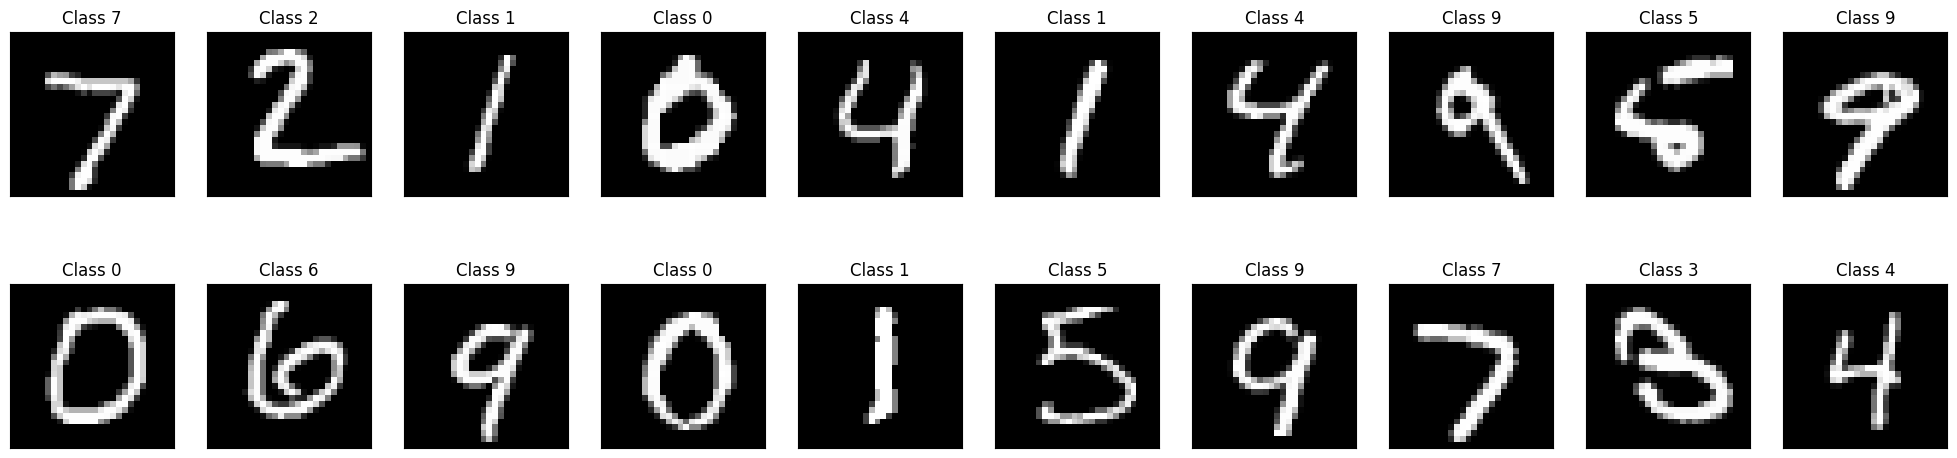

In [6]:
plt.figure(figsize=(25, 6))

# 테스트 데이터에서 20개의 이미지 출력
for i, (x, y) in enumerate(test_data):  # enumerate를 사용하여 이미지(x)와 레이블(y) 가져오기
    if i > 19:  # 처음 20개(0~19)만 출력
        break

    # 서브플롯 생성 (2행 10열 배치, 현재 i번째 위치)
    plt.subplot(2, 10, i + 1)

    # 이미지를 28x28 크기로 변환하여 출력 (MNIST 데이터는 28x28 크기의 흑백 이미지)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')

    # 이미지 제목 설정 (해당 숫자 클래스 표시)
    plt.title("Class {}".format(y))

    # x축, y축 눈금 제거 (불필요한 좌표 값 숨김)
    plt.xticks([])
    plt.yticks([])

plt.show()

### Dataset Loader 생성
- Train dataset 을 train, validation, test dataset 으로 3 분할

In [7]:
# 전체 훈련 데이터의 20%를 검증(validation) 데이터로 설정
valid_size = 0.2

# 배치 크기(batch size) 설정
batch_size = 128

# PyTorch의 random_split()을 사용하여 훈련 데이터(train)와 검증 데이터(validation)로 분할
train_size = int((1 - valid_size) * len(train_data))  # 훈련 데이터 크기 (80%)
valid_size = len(train_data) - train_size  # 검증 데이터 크기 (20%)

# train_data를 train과 validation으로 랜덤하게 분할
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])

# DataLoader를 사용하여 미니배치 단위로 데이터 로딩
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)  # 훈련 데이터 (랜덤 섞기)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)  # 검증 데이터 (랜덤 섞기)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)  # 테스트 데이터 (순차적 로딩)

## Model build

<img src="https://d2l.ai/_images/lenet.svg" width="800" />

In [8]:
# LeNet 모델 정의 (CNN 기반 신경망)
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()  # 부모 클래스(nn.Module) 초기화

        # 첫 번째 합성곱 계층 (입력 채널: 1, 출력 채널: 6, 커널 크기: 5, 패딩: 2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)

        # 두 번째 합성곱 계층 (입력 채널: 6, 출력 채널: 16, 커널 크기: 5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # 첫 번째 완전 연결층 (입력 크기: 16 * 5 * 5, 출력 크기: 120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # 두 번째 완전 연결층 (입력 크기: 120, 출력 크기: 84)
        self.fc2 = nn.Linear(120, 84)

        # 세 번째 완전 연결층 (입력 크기: 84, 출력 크기: 10) → 10개의 클래스 (0~9)
        self.fc3 = nn.Linear(84, 10)

        # 풀링 계층 (최대 풀링, 커널 크기: 2)
        self.maxpool = nn.MaxPool2d(2)

        # 활성화 함수 (ReLU)
        self.relu = nn.ReLU()

        # Dropout 추가 (과적합 방지)
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 확률 50%

    # 순전파(Forward) 연산 정의
    def forward(self, x):
        x = self.relu(self.conv1(x))  # 1st Conv → ReLU
        x = self.maxpool(x)           # 1st MaxPooling

        x = self.relu(self.conv2(x))  # 2nd Conv → ReLU
        x = self.maxpool(x)           # 2nd MaxPooling

        # 출력을 1차원으로 평탄화 (Flatten)
        x = torch.flatten(x, 1)

        x = self.relu(self.fc1(x))  # 1st Fully Connected → ReLU
        x = self.dropout(x)         # Dropout 적용

        x = self.relu(self.fc2(x))  # 2nd Fully Connected → ReLU
        x = self.dropout(x)         # Dropout 적용

        out = self.fc3(x)           # 3rd Fully Connected (출력층)

        return out  # 최종 출력 (10개 클래스에 대한 점수)

In [9]:
# LeNet 모델 객체 생성
model = LeNet()

# 모델 구조 출력
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
# train_loader에서 첫 번째 배치의 데이터(특성) 가져오기
first_batch_data = next(iter(train_loader))[0]

# 출력 형태 확인 [배치 크기, 채널 수, 높이, 너비]
print(first_batch_data.shape)

torch.Size([128, 1, 28, 28])


In [11]:
# 첫 번째 배치 데이터를 모델에 전달하여 순전파 수행
model(next(iter(train_loader))[0])

tensor([[-0.0062, -0.1041,  0.1722,  ..., -0.0953, -0.0011, -0.0648],
        [-0.1340, -0.0206,  0.2653,  ..., -0.1429,  0.1790, -0.1104],
        [-0.0463, -0.1615,  0.3669,  ...,  0.0026,  0.1560, -0.0172],
        ...,
        [-0.1073, -0.1231,  0.1813,  ..., -0.1061,  0.0946, -0.0738],
        [ 0.0494, -0.0687,  0.3057,  ...,  0.0387,  0.0465, -0.0809],
        [-0.0018, -0.1552,  0.1558,  ..., -0.0691,  0.0564, -0.0426]],
       grad_fn=<AddmmBackward0>)

### Model Summary

In [12]:
# 모델의 상태 딕셔너리(state_dict)에서 각 가중치 텐서의 이름과 파라미터 수 출력
for k, v in model.state_dict().items():
    print(k, v.numel())

# 모델의 전체 파라미터 수 출력
print("Total parameters :", sum(p.numel() for p in model.parameters()))

conv1.weight 150
conv1.bias 6
conv2.weight 2400
conv2.bias 16
fc1.weight 48000
fc1.bias 120
fc2.weight 10080
fc2.bias 84
fc3.weight 840
fc3.bias 10
Total parameters : 61706


### Loss Function

In [13]:
# 손실 함수 정의 (CrossEntropyLoss: 분류 문제에서 사용)
criterion = nn.CrossEntropyLoss()

# 모델을 지정한 장치(GPU 또는 CPU)로 이동
model.to(device)

# PyTorch 2.0에서 권장하는 `torch.compile()` 적용
model = torch.compile(model)
model

OptimizedModule(
  (_orig_mod): LeNet(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [14]:
# 학습률 설정
lr = 0.01

# SGD(확률적 경사 하강법) 옵티마이저 정의
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# 학습률 스케줄러 (5 에포크마다 학습률을 0.5배 감소)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [15]:
LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []
EPOCHS = 10  # 총 에폭 수 설정

for epoch in range(EPOCHS):

    model.train()  # 모델을 훈련 모드로 설정

    train_loss = 0  # 훈련 손실을 누적할 변수 초기화
    train_acc = 0   # 훈련 정확도를 누적할 변수 초기화
    total_train_samples = 0  # 전체 샘플 개수

    for x, y in train_loader:  # 훈련 데이터셋을 배치 단위로 불러옴
        x, y = x.to(device), y.to(device)  # 데이터를 현재 디바이스(CPU 또는 GPU)로 이동

        optimizer.zero_grad()  # 옵티마이저의 그라디언트 초기화

        z = model(x)  # 모델을 통해 예측값(z) 계산
        loss = criterion(z, y)  # 손실 함수를 통해 손실 계산
        train_loss += loss.item()  # 배치 손실을 누적
        y_pred = z.argmax(1)     # 예측값 중 가장 높은 값을 가진 인덱스 추출
        train_acc += (y_pred == y).sum().item()  # 정확한 예측 수 누적
        total_train_samples += y.size(0)  # 현재 배치의 전체 샘플 개수 누적

        loss.backward()  # 손실에 대한 그라디언트 계산(역전파)
        optimizer.step()  # 모델의 가중치 업데이트

    # 학습률 업데이트
    scheduler.step()

    train_loss /= len(train_loader)  # 평균 훈련 손실 계산
    train_acc = train_acc / total_train_samples  # 정확도 계산 (맞춘 개수 / 전체 개수)
    LOSS.append(train_loss)
    ACC.append(train_acc)

    model.eval()   # 모델을 평가 모드로 설정

    val_loss = 0  # 검증 손실을 누적할 변수 초기화
    val_acc = 0   # 검증 정확도를 누적할 변수 초기화
    total_val_samples = 0

    with torch.inference_mode():
        for x, y in valid_loader:  # 검증 데이터셋을 배치 단위로 불러옴
            x, y = x.to(device), y.to(device)

            z = model(x)
            loss = criterion(z, y)
            val_loss += loss.item()
            y_pred = z.argmax(1)
            val_acc += (y_pred == y).sum().item()
            total_val_samples += y.size(0)

    val_loss /= len(valid_loader)  # 평균 검증 손실 계산
    val_acc  = val_acc / total_val_samples
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)

    # 에폭별 훈련 및 검증 결과 출력
    print(f'epoch {epoch} ==> train loss: {train_loss:.5f},  validation loss: {val_loss:.5f}',
                                            f'train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

epoch 0 ==> train loss: 2.24748,  validation loss: 1.98228 train acc: 0.16004, validation acc: 0.60567
epoch 1 ==> train loss: 1.27407,  validation loss: 0.47184 train acc: 0.58327, validation acc: 0.87675
epoch 2 ==> train loss: 0.60840,  validation loss: 0.25650 train acc: 0.80754, validation acc: 0.92792
epoch 3 ==> train loss: 0.41639,  validation loss: 0.18771 train acc: 0.87596, validation acc: 0.94433
epoch 4 ==> train loss: 0.32939,  validation loss: 0.15919 train acc: 0.90490, validation acc: 0.95175
epoch 5 ==> train loss: 0.27901,  validation loss: 0.14312 train acc: 0.92025, validation acc: 0.95558
epoch 6 ==> train loss: 0.26442,  validation loss: 0.13777 train acc: 0.92477, validation acc: 0.95825
epoch 7 ==> train loss: 0.24370,  validation loss: 0.12994 train acc: 0.92988, validation acc: 0.96050
epoch 8 ==> train loss: 0.23841,  validation loss: 0.12193 train acc: 0.93277, validation acc: 0.96267
epoch 9 ==> train loss: 0.22253,  validation loss: 0.11579 train acc: 0.9

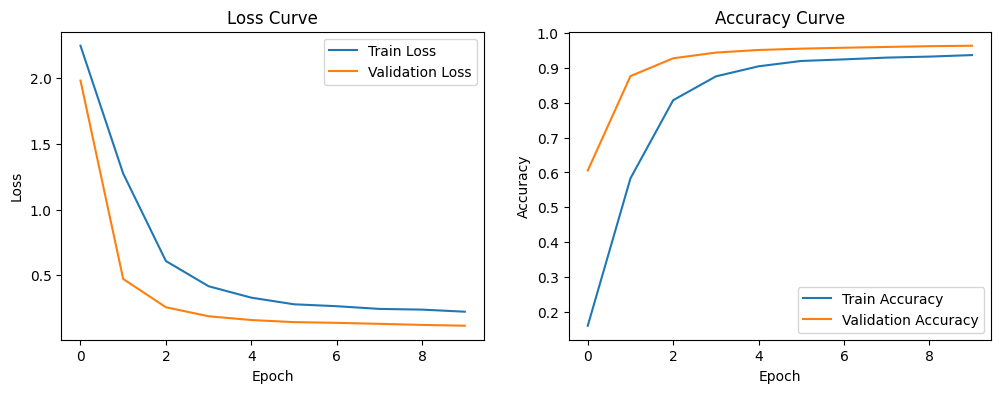

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 훈련 손실과 검증 손실 그래프
ax1.plot(LOSS, label='Train Loss')
ax1.plot(VAL_LOSS, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Curve')

# 훈련 정확도와 검증 정확도 그래프
ax2.plot(ACC, label='Train Accuracy')
ax2.plot(VAL_ACC, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Accuracy Curve')

plt.show()

## Model 평가 - Test set 사용

In [17]:
predictions = []  # 모델의 예측을 저장할 리스트
labels = []  # 실제 레이블을 저장할 리스트

model.eval()  # 모델을 평가 모드로 설정

# 테스트 로더를 통해 테스트 데이터셋의 배치를 순회
with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)  # 데이터를 현재 디바이스(CPU 또는 GPU)로 이동
        z = model(x)  # 모델에 데이터를 전달하여 예측값(z) 계산
        y_pred = z.argmax(1) # 예측값 중 가장 높은 값을 가진 인덱스 추출

        # 예측 결과와 실제 레이블을 CPU로 이동 후 numpy 배열로 변환하여 리스트에 추가
        predictions.extend(y_pred.numpy(force=True))
        labels.extend(y.numpy(force=True))

# 예측값과 실제 레이블이 일치하는 인덱스 추출
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
# 예측값과 실제 레이블이 일치하지 않는 인덱스 추출
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

# 정확도 계산: 정확한 예측의 수를 전체 예측의 수로 나눈 후 백분율로 변환
print("accuracy = {:.2f}%".format(len(correct_indices) / len(predictions) * 100))

accuracy = 96.87%


## Category 별 분류 성능 측정

Accuracy of 0 = 98.98%
Accuracy of 1 = 99.12%
Accuracy of 2 = 96.80%
Accuracy of 3 = 96.53%
Accuracy of 4 = 96.03%
Accuracy of 5 = 96.75%
Accuracy of 6 = 97.39%
Accuracy of 7 = 95.43%
Accuracy of 8 = 96.30%
Accuracy of 9 = 95.14%


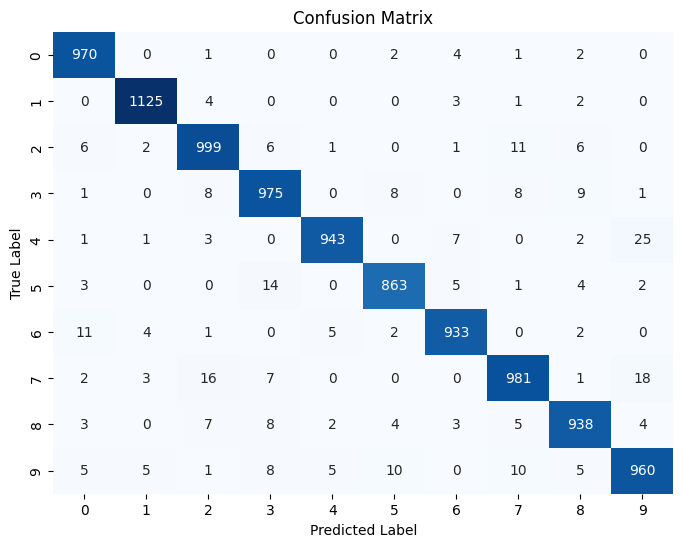

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 계산
cm = confusion_matrix(labels, predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  # 색상 변경 및 컬러바 제거 가능
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# 클래스별 정확도 출력
for i in range(10):
    if cm[i].sum() > 0:  # ZeroDivisionError 방지
        accuracy = cm[i][i] / cm[i].sum() * 100
        print(f"Accuracy of {i} = {accuracy:.2f}%")
    else:
        print(f"Accuracy of {i} = No samples")

plt.show()

# 실습 : fashion MNIST 를 이용하여 위와 동일한 작업

Label	Class

0	T-shirt/top  
1	Trouser  
2	Pullover  
3	Dress  
4	Coat  
5	Sandal  
6	Shirt  
7	Sneaker  
8	Bag  
9	Ankle boot

In [19]:
composed = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1,), (0.3,))])

In [20]:
# load mnist data
train_data = dsets.FashionMNIST(root='./data', train=True, download=True, transform=composed)

test_data = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.38MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [21]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

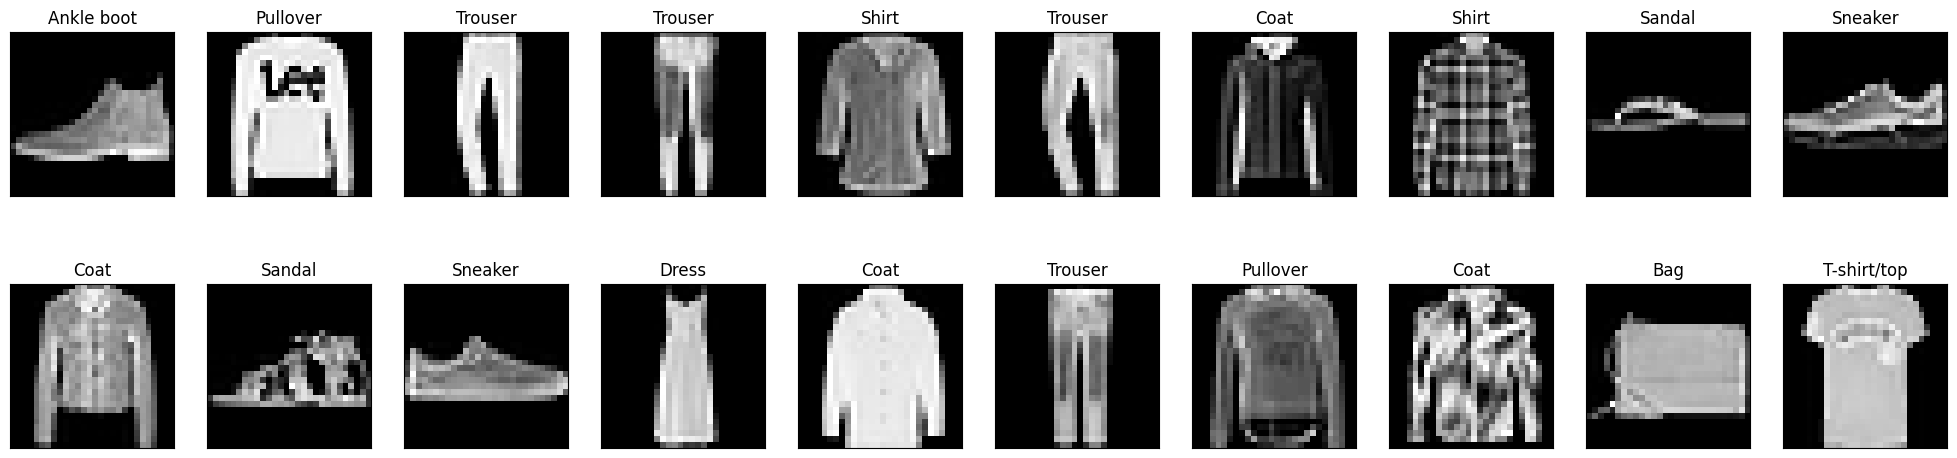

In [22]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    plt.imshow(x.numpy().reshape(28, 28), cmap='gray')
    plt.title(class_names[y])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [23]:
# Your code here